Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/Colab Notebooks/CNN/SkinCancerData.zip" > /dev/null

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/SkinCancerData/Train")
data_dir_test = pathlib.Path('/content/SkinCancerData/Test')
data_dir_train_Augmentor= '/content/SkinCancerData/Train/' #additional / is needed at the end

#data_dir_train = pathlib.Path("C:\\Users\\praka\Documents\\7.4 Melanoma Detection Assignment\\SkinCancerData\\Train")
#data_dir_test = pathlib.Path('C:\\Users\\praka\\Documents\\7.4 Melanoma Detection Assignment\\SkinCancerData\\Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

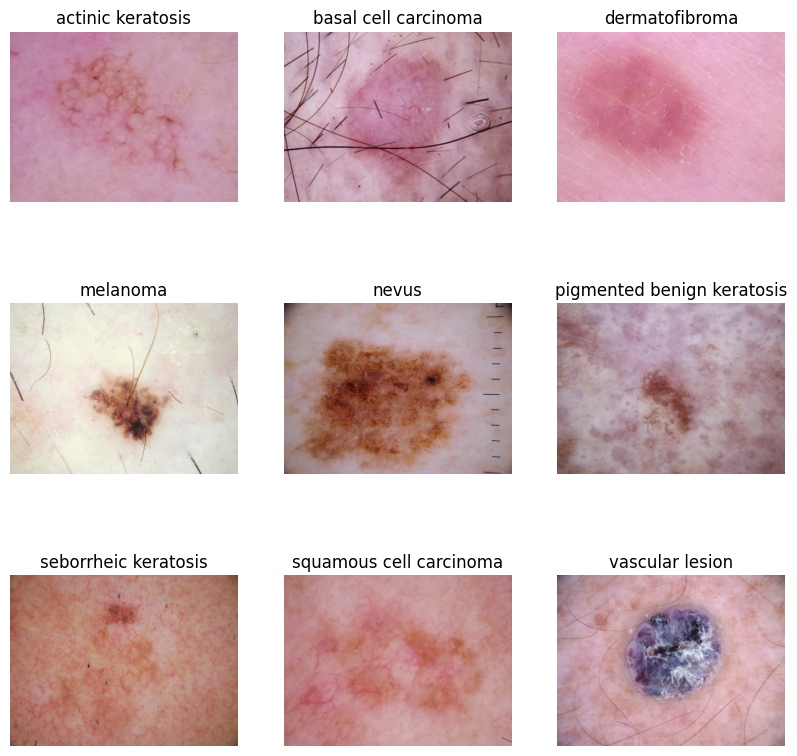

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.8789215


In [15]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 21s 130ms/step - loss: 2.1322 - accuracy: 0.1881 - val_loss: 2.0884 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 2.0561 - accuracy: 0.1998 - val_loss: 2.0432 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 2.0379 - accuracy: 0.1975 - val_loss: 2.0226 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 2.0052 - accuracy: 0.2109 - val_loss: 1.9546 - val_accuracy: 0.2662
Epoch 5/20
56/56 [==============================] - 3s 60ms/step - loss: 2.0058 - accuracy: 0.2232 - val_loss: 1.9055 - val_accuracy: 0.2819
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.8852 - accuracy: 0.2846 - val_loss: 1.8934 - val_accuracy: 0.2640
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.8086 - accuracy: 0.3393 - val_loss: 1.9362 - val_accuracy: 0.2103
Epoch 8/20
56/56 [====

### Visualizing training results

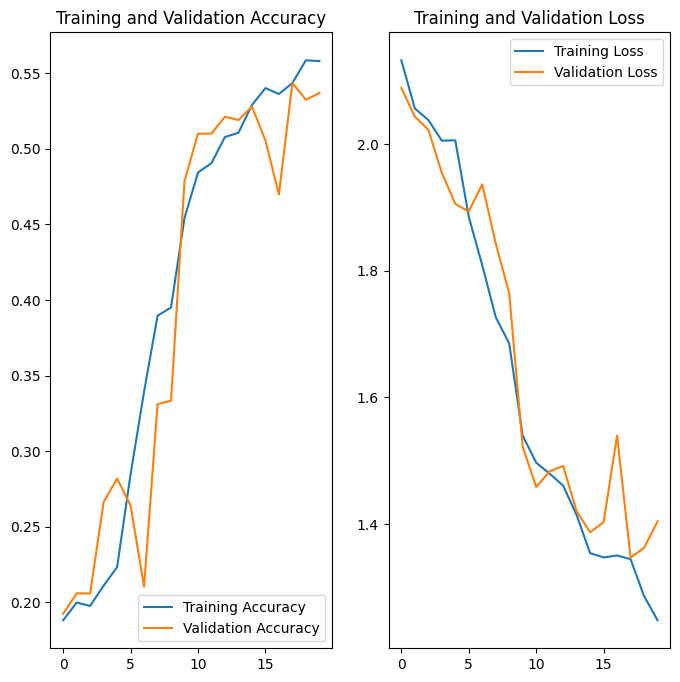

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Based on the above results we can observe that the  model is underfit as the training Accuracy and Validation Accuracy both are low

### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

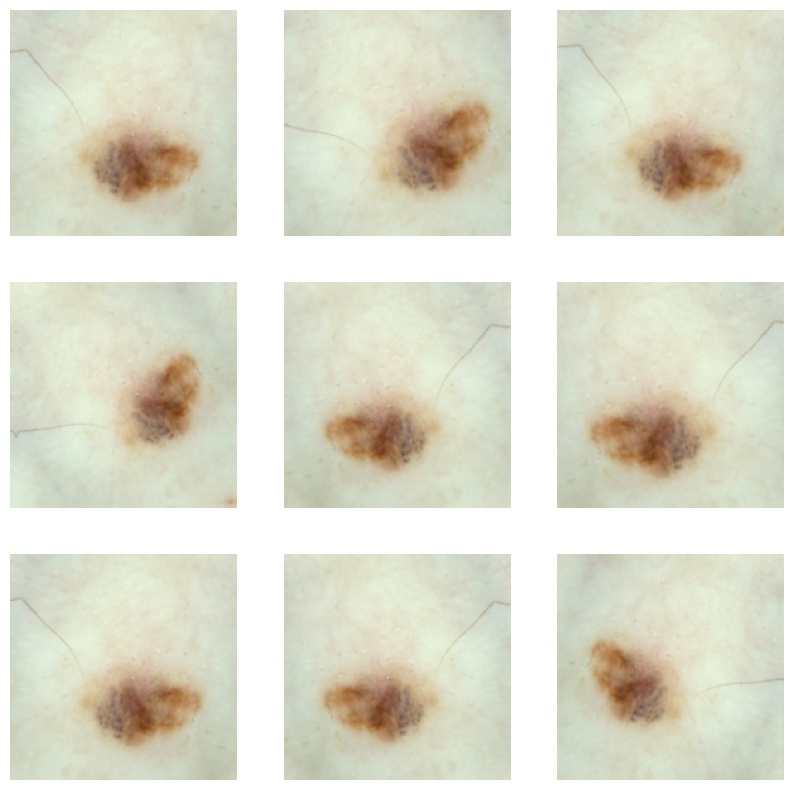

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])


### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 78ms/step - loss: 2.1122 - accuracy: 0.1987 - val_loss: 2.1155 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 2.0566 - accuracy: 0.1853 - val_loss: 2.0476 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0398 - accuracy: 0.1892 - val_loss: 2.0447 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 2.0285 - accuracy: 0.2165 - val_loss: 1.9178 - val_accuracy: 0.2349
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 2.0237 - accuracy: 0.2132 - val_loss: 2.0039 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 1.9299 - accuracy: 0.2779 - val_loss: 1.8298 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 1.8008 - accuracy: 0.3276 - val_loss: 1.6954 - val_accuracy: 0.3736
Epoch 8/20
56

### Visualizing the results

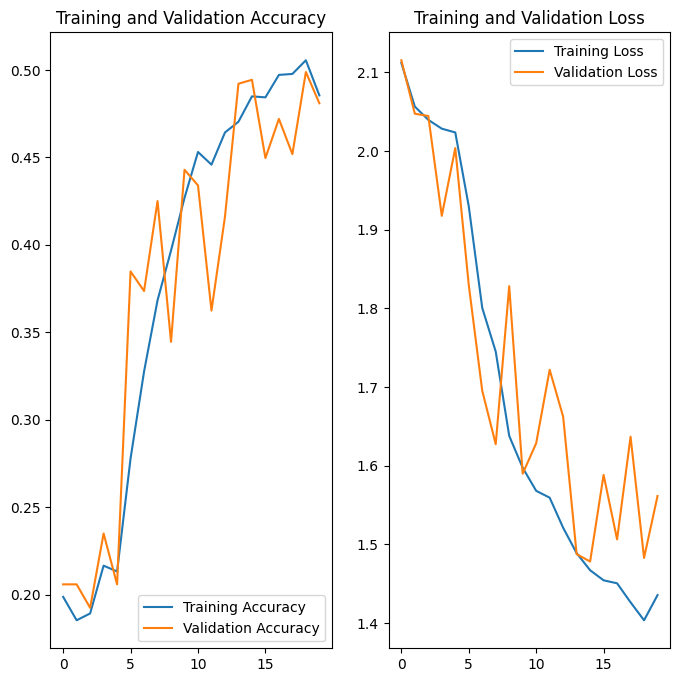

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
for i in class_names:
  count = len(list(data_dir_train.glob(i+'/*.jpg')))
  print('Number of samples in class ',i,':', count)

Number of samples in class  actinic keratosis : 114
Number of samples in class  basal cell carcinoma : 376
Number of samples in class  dermatofibroma : 95
Number of samples in class  melanoma : 438
Number of samples in class  nevus : 357
Number of samples in class  pigmented benign keratosis : 462
Number of samples in class  seborrheic keratosis : 77
Number of samples in class  squamous cell carcinoma : 181
Number of samples in class  vascular lesion : 139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
##### *Ans: seborrheic keratosis has least number of Samples*
#### - Which classes dominate the data in terms proportionate number of samples?
##### *Ans: pigmented benign keratosis dominates the data in terms of number of samples*

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train_Augmentor+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/SkinCancerData/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78E06C45BC40>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/SkinCancerData/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78E0AB937AC0>: 100%|██████████| 500/500 [00:21<00:00, 23.65 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/SkinCancerData/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78E090712DA0>: 100%|██████████| 500/500 [00:20<00:00, 24.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/SkinCancerData/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78E0E124FAC0>: 100%|██████████| 500/500 [01:24<00:00,  5.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/SkinCancerData/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x78E0AB934FD0>: 100%|██████████| 500/500 [01:21<00:00,  6.16 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/SkinCancerData/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78E06C434F10>: 100%|██████████| 500/500 [00:16<00:00, 29.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/SkinCancerData/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78E0AB9C3A90>: 100%|██████████| 500/500 [00:38<00:00, 12.93 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/SkinCancerData/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78E06C436080>: 100%|██████████| 500/500 [00:15<00:00, 32.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/SkinCancerData/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78E0AB9C3A90>: 100%|██████████| 500/500 [00:16<00:00, 30.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(path_list_new))

4500


In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print (len(lesion_list_new))

4500


In [33]:
path_list_original = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list_original))

2239


In [34]:
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print (len(lesion_list_original))

2239


In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))

In [37]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)


<ipython-input-37-3e8c25975da0>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [38]:
new_df.head()

,Path,Label
0,/content/SkinCancerData/Train/actinic keratosi...,actinic keratosis
1,/content/SkinCancerData/Train/actinic keratosi...,actinic keratosis
2,/content/SkinCancerData/Train/actinic keratosi...,actinic keratosis
3,/content/SkinCancerData/Train/actinic keratosi...,actinic keratosis
4,/content/SkinCancerData/Train/actinic keratosi...,actinic keratosis


In [39]:
print(len(new_df))
new_df['Label'].value_counts()

6739


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
#data_dir_train="C:\\Users\\praka\Documents\\7.4 Melanoma Detection Assignment\\SkinCancerData2\\Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here
model = Sequential([
  #data_augmentation,
  #Rescaling(1./255, input_shape=(img_height, img_width, 3))
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes, activation='softmax')
])


In [44]:
model123 = Sequential()
model123.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model123.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model123.add(layers.MaxPool2D(pool_size=(2,2)))
model123.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model123.add(layers.MaxPool2D(pool_size=(2,2)))
model123.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model123.add(layers.MaxPool2D(pool_size=(2,2)))
model123.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model123.add(layers.MaxPool2D(pool_size=(2,2)))
model123.add(layers.Dropout(0.5))
model123.add(layers.Flatten())
model123.add(layers.Dense(256,activation='relu'))
model123.add(layers.Dropout(0.25))
model123.add(layers.Dense(128,activation='relu'))
model123.add(layers.Dropout(0.25))
model123.add(layers.Dense(64,activation='relu'))
model123.add(layers.Dropout(0.25))
model123.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here, use 30 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 52s 274ms/step - loss: 2.0930 - accuracy: 0.1771 - val_loss: 1.8687 - val_accuracy: 0.2932
Epoch 2/30
169/169 [==============================] - 29s 164ms/step - loss: 1.8356 - accuracy: 0.2773 - val_loss: 1.7054 - val_accuracy: 0.3304
Epoch 3/30
169/169 [==============================] - 29s 166ms/step - loss: 1.7222 - accuracy: 0.3464 - val_loss: 1.7567 - val_accuracy: 0.3489
Epoch 4/30
169/169 [==============================] - 30s 173ms/step - loss: 1.5874 - accuracy: 0.3885 - val_loss: 1.4443 - val_accuracy: 0.4447
Epoch 5/30
169/169 [==============================] - 29s 166ms/step - loss: 1.5171 - accuracy: 0.4106 - val_loss: 1.4685 - val_accuracy: 0.4336
Epoch 6/30
169/169 [==============================] - 29s 169ms/step - loss: 1.4577 - accuracy: 0.4290 - val_loss: 1.4317 - val_accuracy: 0.4432
Epoch 7/30
169/169 [==============================] - 29s 166ms/step - loss: 1.3941 - accuracy: 0.4501 - val_loss: 1.3444 - val_accuracy: 0.4

#### **Todo:**  Visualize the model results

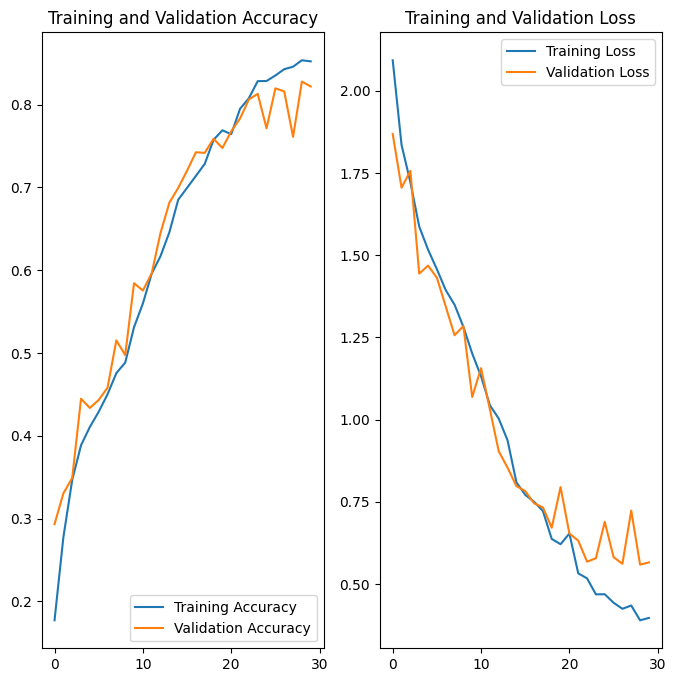

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

##### *Yes after addressing the imbalancing using Augmentor library both Training Accuracy and Validation accuracy have increased enormously*

## Training Acccuracy: 85.22
## Validation Accuracy: 82.18

